## Machine Learning Classification: Football Player Goal Prediction

<img src="https://i.gadgets360cdn.com/large/fifa-19-neymar_1532690317368.jpg" style="width: 800px;">

## Future Plan 

#### If we can get the real time analysis from folum and real time heat map data

In [2]:
# Data preprocessing
!pip install statsbomb
!pip install scikit-plot
!pip install imblearn
!pip install seaborn
 
# Plotting
import folium
import gmaps 
import gmaps.datasets 
import json
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import statsbomb as sb
 
# Machine learning
from collections import Counter
from folium.plugins import HeatMapWithTime
from imblearn.over_sampling import SMOTE
from matplotlib.patches import Arc, Rectangle, ConnectionPatch, Patch
from pandas.io.json import json_normalize
from sklearn import preprocessing, model_selection, svm, metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier

%matplotlib inline

pd.options.mode.chained_assignment = None

with open('./data/events/69142.json') as data_file:
    data = json.load(data_file)
df = json_normalize(data, sep = '_')

Using TensorFlow backend.


In [19]:
def generateBaseMap(default_location=[41.3809, 2.1228], default_zoom_start=18):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
base_map = generateBaseMap()
base_map

In [4]:
def draw_pitch(ax, colour = None, edge = 'black'):
    
    Background = Rectangle([-10,-10], width = 135, height = 95, fill = False)
    Pitch = Rectangle([0,0], width = 120, height = 80, edgecolor = edge, fill = False)
    
    if colour:
        Background = Rectangle([-10,-10], width = 135, height = 95, color = colour)
        Pitch = Rectangle([0,0], width = 120, height = 80, edgecolor = edge, facecolor = colour)
    
    LeftPenalty = Rectangle([0,18], width = 18, height = 44, edgecolor = edge, fill = False)
    RightPenalty = Rectangle([102,18], width = 18, height = 44, edgecolor = edge, fill = False)
    midline = ConnectionPatch([60,0], [60,80], 'data', 'data', color = edge)
    
    LeftSixYard = Rectangle([0,30], width = 6, height = 20, edgecolor = edge, fill = False)
    RightSixYard = Rectangle([114,30], width = 6, height = 20, edgecolor = edge, fill = False)
    
    LeftGoal = Rectangle([-3,36], width = 3, height = 8, linewidth = 1, edgecolor = 'black', fill = False)
    RightGoal = Rectangle([120,36], width = 3, height = 8, linewidth = 1, edgecolor = 'black', fill = False)
    
    centreCircle = plt.Circle((60,40), 8.1, color = edge, fill = False)
    centreSpot = plt.Circle((60,40), 0.71, color = edge)
    
    leftPenSpot = plt.Circle((12,40), 0.71, color = edge)
    rightPenSpot = plt.Circle((108,40), 0.71, color = edge)
    leftArc = Arc((14, 40), height = 16.2, width = 16.2, angle = 0, theta1 = 300, theta2 = 60, color = edge)
    rightArc = Arc((106, 40), height = 16.2, width = 16.2, angle = 0, theta1 = 120, theta2 = 240, color = edge)
    
    element = [Background, Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc, LeftGoal, RightGoal]
    for i in element:
        ax.add_patch(i)

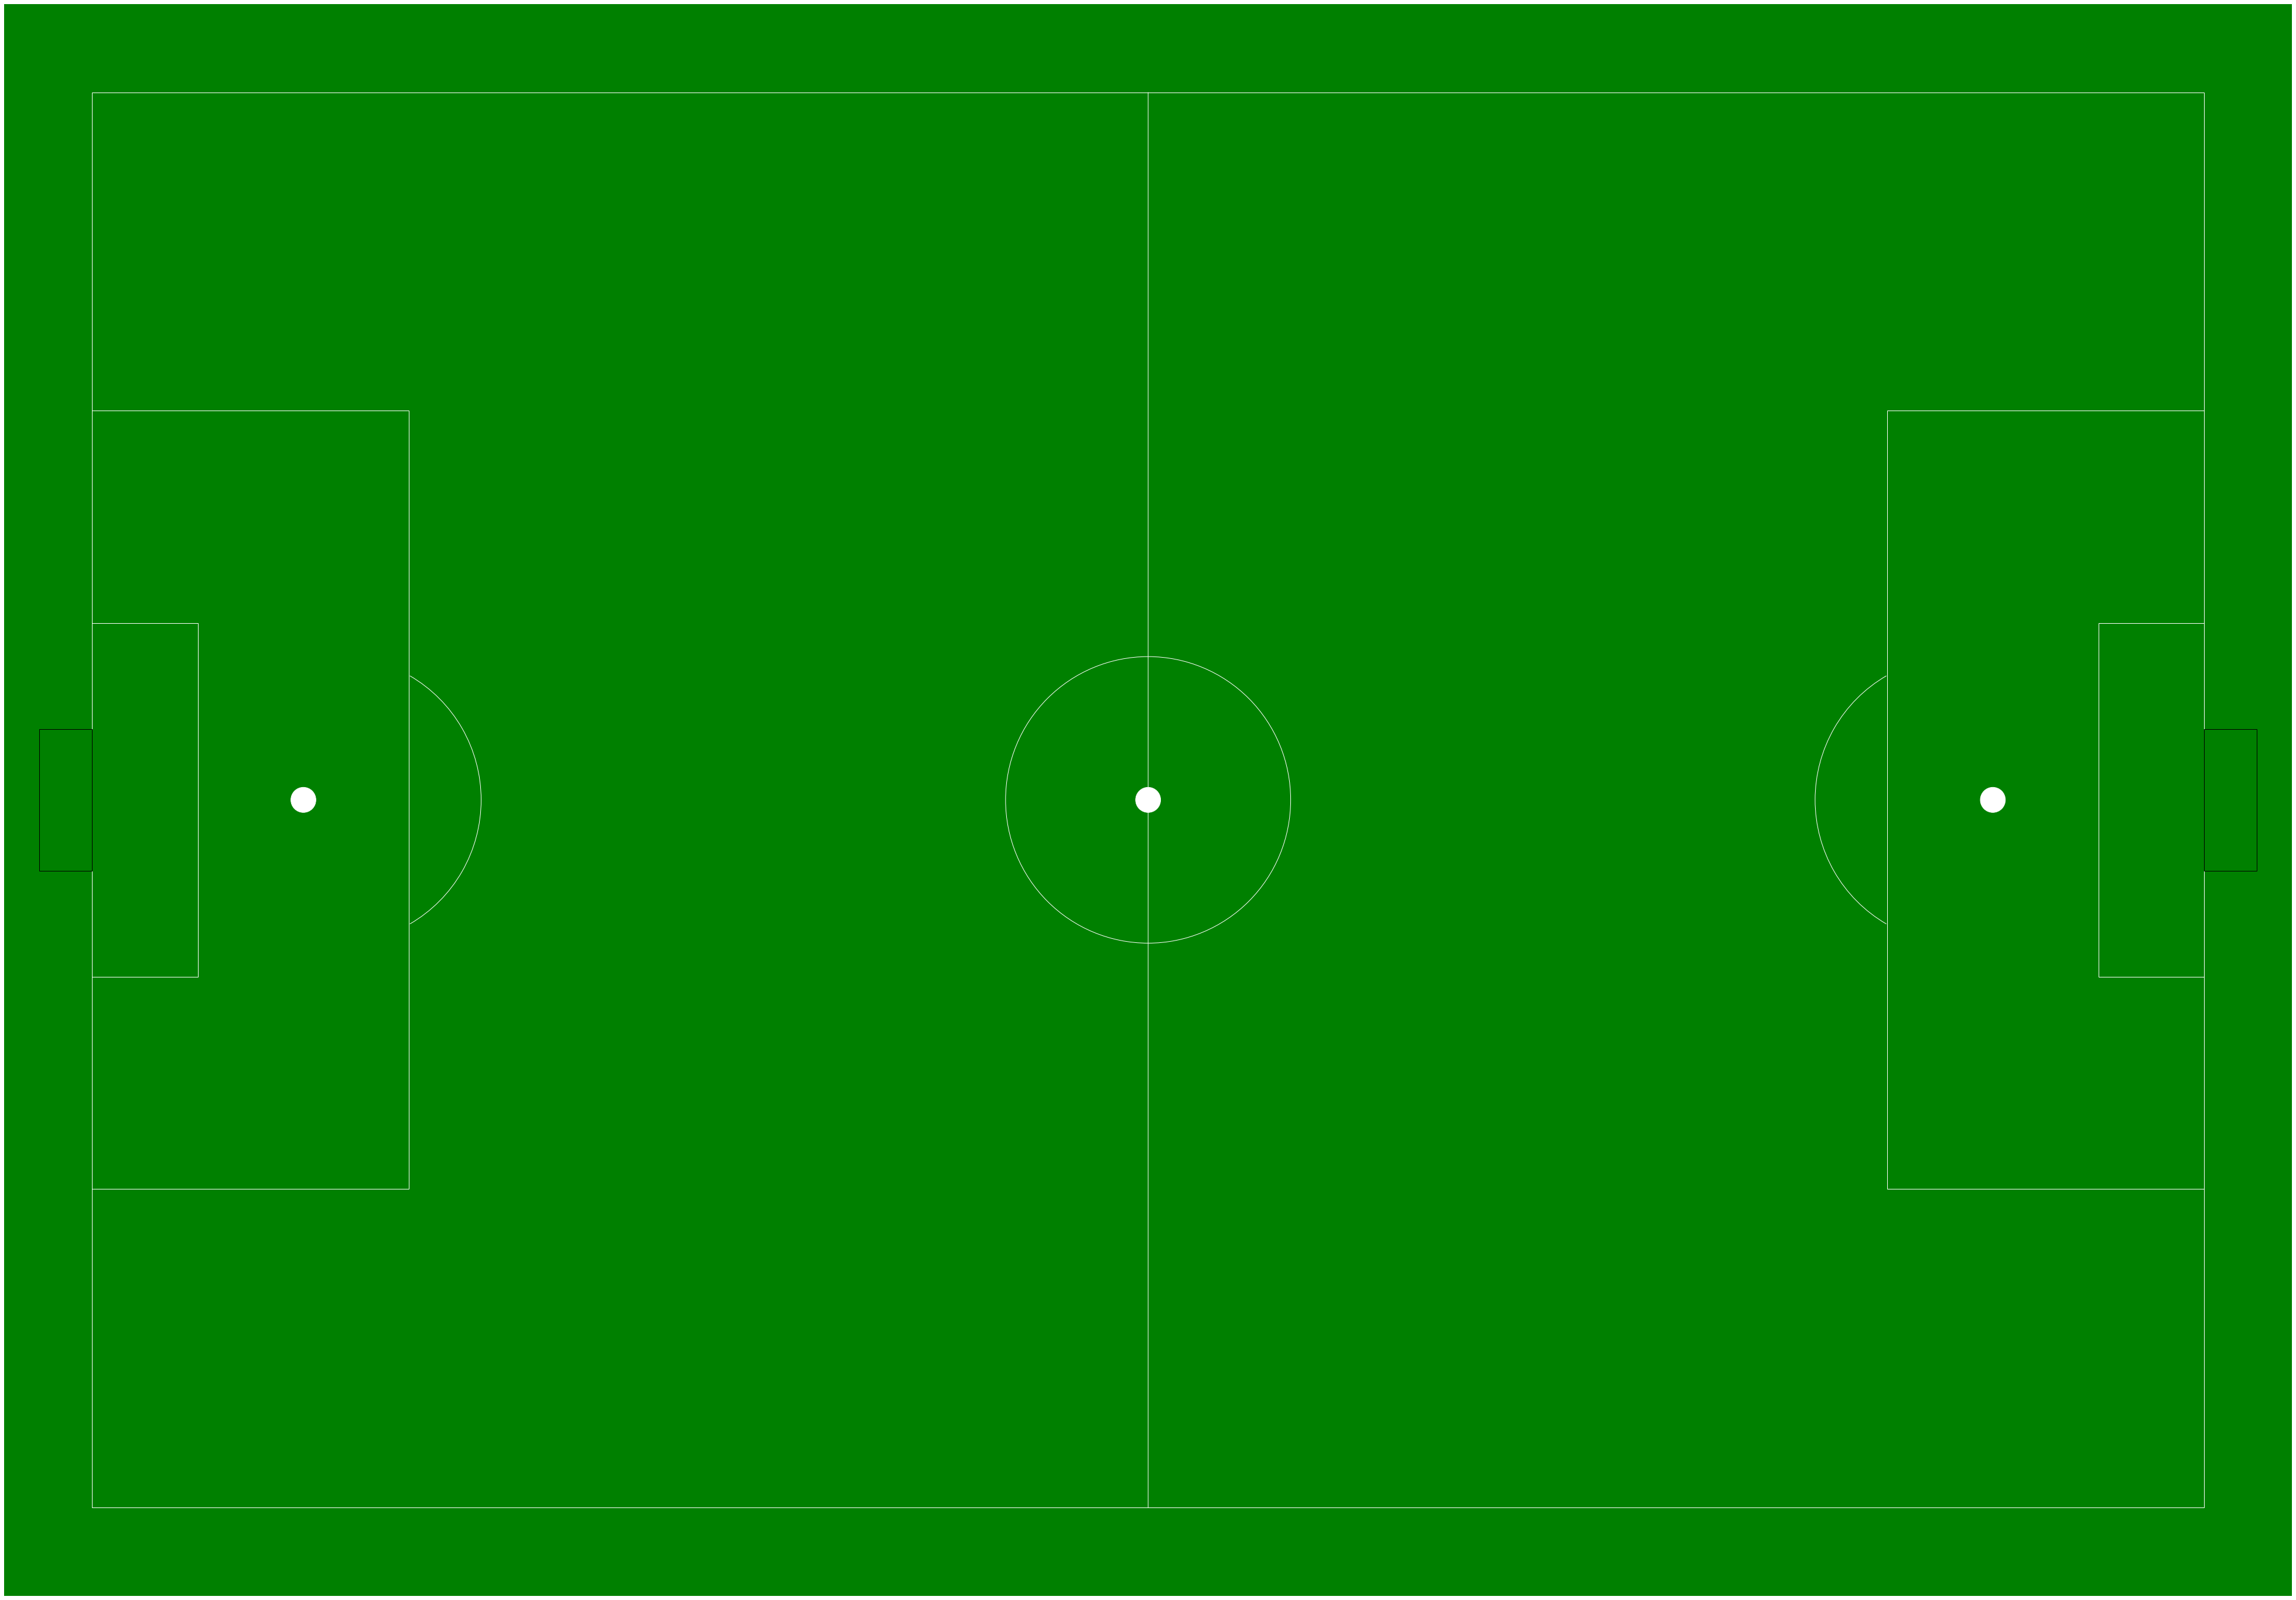

In [5]:
fig = plt.figure()
fig.set_size_inches(70, 50)
ax=fig.add_subplot(1, 1, 1)
draw_pitch(ax, 'green', 'white')
plt.ylim(-5, 85)
plt.xlim(-5, 125)
plt.axis('off')
plt.show()

In [6]:
def heat_pass_shot_map(ax, data, player_name, passes = False, shots = False, heatmap = False):
    shot_data = data[(data['type_name'] == 'Shot') & (data['player_name'] == player_name)]
    pass_data = data[(data['type_name'] == 'Pass') & (data['player_name'] == player_name)]
    action_data = data[(data['player_name'] == player_name)][:-1]
    
    ax.title.set_text(player_name)

    if heatmap:
        draw_pitch(ax)
    else:
        draw_pitch(ax, 'green', 'white')
    
    if passes:
        for i in range(len(pass_data)):
            color = 'blue' if pass_data.iloc[i]['period'] == 1 else 'red'
            ax.annotate('', xy = (pass_data.iloc[i]['pass_end_location'][0], pass_data.iloc[i]['pass_end_location'][1]), xycoords = 'data',
                xytext = (pass_data.iloc[i]['location'][0], pass_data.iloc[i]['location'][1]), textcoords = 'data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color=color))
    
    if shots:
        for i in range(len(shot_data)):
            color = 'black' 
            if shot_data.iloc[i]['shot_outcome_name'] == 'Goal':
                color ='yellow'
            elif shot_data.iloc[i]['shot_outcome_name'] == 'Saved':
                color = 'purple'
            ax.annotate('', xy = (shot_data.iloc[i]['shot_end_location'][0], shot_data.iloc[i]['shot_end_location'][1]), xycoords = 'data',
                xytext = (shot_data.iloc[i]['location'][0], shot_data.iloc[i]['location'][1]), textcoords = 'data',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color=color))
    
    if heatmap:
        x_coord = [i[0] for i in action_data['location']]
        y_coord = [i[1] for i in action_data['location']]
        sns.kdeplot(x_coord, y_coord, shade = 'True', color = 'green', n_levels = 30, ax=ax)
    

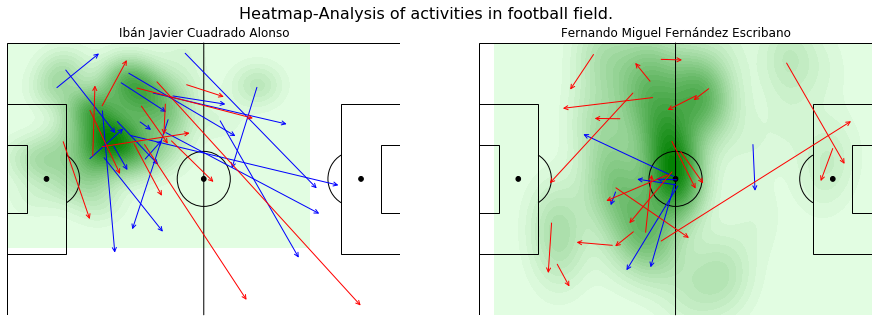

In [7]:
fig = plt.figure(edgecolor='green')
fig.set_size_inches(15.5, 5)
fig.suptitle('Heatmap-Analysis of activities in football field.', fontsize=16)

ax1=fig.add_subplot(1, 2, 1)
ax2=fig.add_subplot(1, 2, 2)


heat_pass_shot_map(ax1, df, 'Ibán Javier Cuadrado Alonso', passes = True, heatmap = True)
heat_pass_shot_map(ax2, df, 'Fernando Miguel Fernández Escribano', passes = True, heatmap = True)


ax1.set(ylim=(0, 80))
ax1.set(xlim=(0, 120))
ax1.axis('off')
ax2.set(ylim=(0, 80))
ax2.set(xlim=(0, 120))
ax2.axis('off')
plt.show()

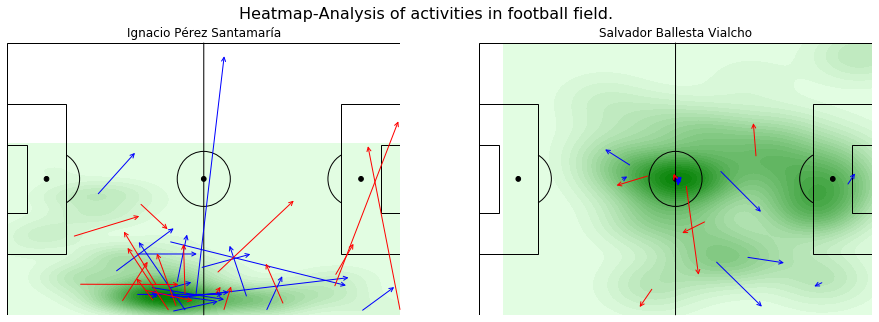

In [8]:
fig = plt.figure(edgecolor='green')
fig.set_size_inches(15.5, 5)
fig.suptitle('Heatmap-Analysis of activities in football field.', fontsize=16)

ax1=fig.add_subplot(1, 2, 1)
ax2=fig.add_subplot(1, 2, 2)


heat_pass_shot_map(ax1, df, 'Ignacio Pérez Santamaría', passes = True, heatmap = True)
heat_pass_shot_map(ax2, df, 'Salvador Ballesta Vialcho', passes = True, heatmap = True)


ax1.set(ylim=(0, 80))
ax1.set(xlim=(0, 120))
ax1.axis('off')
ax2.set(ylim=(0, 80))
ax2.set(xlim=(0, 120))
ax2.axis('off')
plt.show()

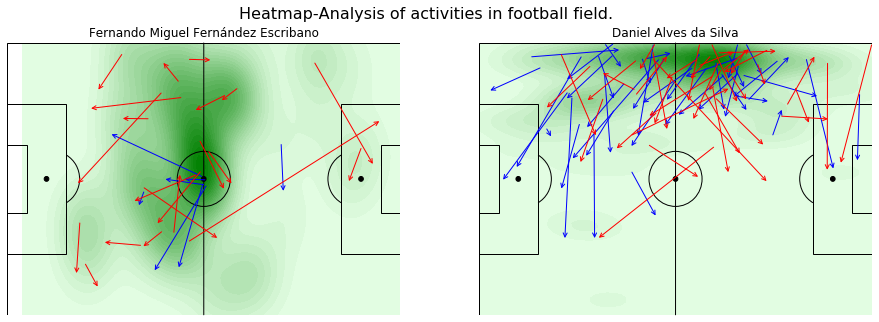

In [9]:
fig = plt.figure(edgecolor='green')
fig.set_size_inches(15.5, 5)
fig.suptitle('Heatmap-Analysis of activities in football field.', fontsize=16)

ax1=fig.add_subplot(1, 2, 1)
ax2=fig.add_subplot(1, 2, 2)


heat_pass_shot_map(ax1, df, 'Fernando Miguel Fernández Escribano', passes = True, heatmap = True)
heat_pass_shot_map(ax2, df, 'Daniel Alves da Silva', passes = True, heatmap = True)


ax1.set(ylim=(0, 80))
ax1.set(xlim=(0, 120))
ax1.axis('off')
ax2.set(ylim=(0, 80))
ax2.set(xlim=(0, 120))
ax2.axis('off')
plt.show()

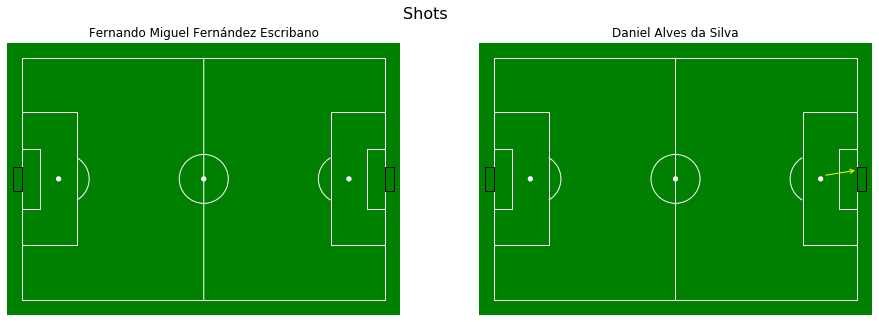

In [10]:
fig = plt.figure(edgecolor='green')
fig.set_size_inches(15.5, 5)
fig.suptitle('Shots', fontsize=16)

ax1=fig.add_subplot(1, 2, 1)
ax2=fig.add_subplot(1, 2, 2)


heat_pass_shot_map(ax1, df, 'Fernando Miguel Fernández Escribano', passes = False, shots = True)
heat_pass_shot_map(ax2, df, 'Daniel Alves da Silva', passes = False, shots = True)


ax1.set(ylim=(-5, 85))
ax1.set(xlim=(-5, 125))
ax1.axis('off')
ax2.set(ylim=(-5, 85))
ax2.set(xlim=(-5, 125))
ax2.axis('off')
plt.show()

In [11]:
import statsbomb as sb

events = sb.Events(event_id='8658')
events.save_data(event_type='shot')  

In [12]:
def draw_horizontal_bar(ax, labels, data, colors, title):
    
    y = [0]
    start = 0
    values = []
    for i in range(0, len(data)):
        values.append((start, data[i]))
        ax.text(start + data[i]-(data[i]/2), 0.45, round(data[i]), fontsize=12, color='white')
        start = data[i]
    ax.broken_barh(values, [0.25, 0.5], facecolors=colors, edgecolor='white', linewidth=2, label=labels)
    ax.set_ylabel(title, rotation=0, labelpad=40, fontsize = 16)
    ax.set_ylim(0,1)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [13]:
pass_count = df[(df['type_name'] == 'Pass')].groupby(['team_name']).count()[['type_name']]
eng_pass = pass_count.iloc[0]['type_name']
nor_pass = pass_count.iloc[1]['type_name']
total_pass = eng_pass + nor_pass

eng_poss = (eng_pass / total_pass)*100
nor_poss = (nor_pass / total_pass)*100

shot_count = df[(df['type_name'] == 'Shot')].groupby(['team_name']).count()[['type_name']]
eng_shot = shot_count.iloc[0]['type_name']
nor_shot = shot_count.iloc[1]['type_name']

ontarget_data = df[(df['type_name'] == 'Shot') &
                   (df['shot_outcome_name'] != 'Off T') &
                   (df['shot_outcome_name'] != 'Blocked') & 
                   (df['shot_outcome_name'] != 'Post')].groupby(['team_name']).count()[['shot_outcome_name']]
eng_ontarget = ontarget_data.iloc[0]['shot_outcome_name']
nor_ontarget = ontarget_data.iloc[1]['shot_outcome_name']

corner_count = df[(df['pass_type_name'] == 'Corner')].groupby(['team_name']).count()[['pass_type_name']]
eng_corner = corner_count.iloc[0]['pass_type_name']
nor_corner = corner_count.iloc[1]['pass_type_name']
foul_count = df[(df['type_name'] == 'Foul Committed')].groupby(['team_name']).count()[['type_name']]

eng_foul = foul_count.iloc[0]['type_name']
nor_foul = foul_count.iloc[1]['type_name']

In [14]:
pass_count

,type_name
team_name,
Barcelona,700
Málaga,357


In [15]:
shot_count

,type_name
team_name,
Barcelona,25
Málaga,9


In [16]:
corner_count

,pass_type_name
team_name,
Barcelona,10
Málaga,7


In [17]:
ontarget_data

,shot_outcome_name
team_name,
Barcelona,15
Málaga,3


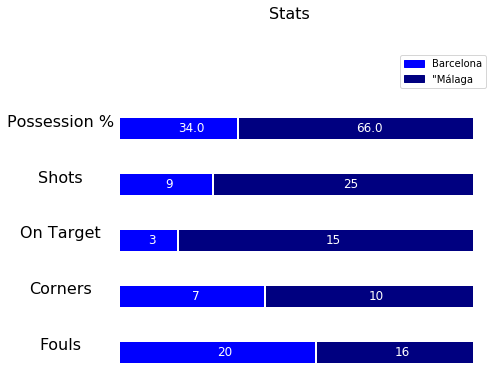

In [18]:
fig = plt.figure()
fig.set_size_inches(7, 6)
fig.suptitle('Stats', fontsize=16)
ax = fig.add_subplot(6, 1, 1)
ax1 = fig.add_subplot(6, 1, 2)
ax2 = fig.add_subplot(6, 1, 3)
ax3 = fig.add_subplot(6, 1, 4)
ax4 = fig.add_subplot(6, 1, 5)
ax5 = fig.add_subplot(6, 1, 6)

# Legend
colors = ('blue', 'navy')
labels = ['Barcelona', '"Málaga']
ax.set_yticks([])
ax.set_xticks([])
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
legends = []
for i in range(0, len(labels)):
    legends.append(Patch(color=colors[i], label=labels[i]))
ax.legend(handles=legends, loc='best')

draw_horizontal_bar(ax1, labels, [nor_poss, eng_poss], colors, "Possession %")
draw_horizontal_bar(ax2, labels, [nor_shot, eng_shot], colors, "Shots")
draw_horizontal_bar(ax3, labels, [nor_ontarget, eng_ontarget], colors, "On Target")
draw_horizontal_bar(ax4, labels, [nor_corner, eng_corner], colors, "Corners")
draw_horizontal_bar(ax5, labels, [nor_foul, eng_foul], colors, "Fouls")

plt.show()